In [1]:
import os
os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tifffile as tiff
from glob import glob
import albumentations as albu
from skimage.io import imread
from tqdm import tqdm
import gc

# TensorFlow Imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, LeakyReLU, BatchNormalization, Activation, Add, Input, Multiply, Conv2DTranspose)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, jaccard_score

2025-04-16 05:23:44.209111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744781024.408979      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744781024.464153      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ------------------------------ #
#        Dice Coefficient        #
# ------------------------------ #
def Dice_Coef(y_true, y_pred, smooth=1e-6):
    y_true = K.flatten(K.cast(y_true, tf.float32))
    y_pred = K.flatten(K.cast(y_pred, tf.float32))
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return ((2. * intersection + smooth) / (union + smooth))

def Dice_Loss(y_true, y_pred):
    return 1 - Dice_Coef(y_true, y_pred)

In [3]:
# ------------------------------ #
#       Jaccard & Accuracy       #
# ------------------------------ #
def Jaccard_Index(y_true, y_pred, smooth=1e-6):
    y_true = K.flatten(K.cast(y_true, tf.float32))
    y_pred = K.flatten(K.cast(y_pred, tf.float32))
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def Accuracy(y_true, y_pred):
    y_true = K.flatten(K.cast(y_true, tf.float32))
    y_pred = K.flatten(K.cast(y_pred > 0.5, tf.float32))  # Threshold prediction
    return K.mean(K.equal(y_true, y_pred))

In [4]:
# ------------------------------ #
#        Load Data Function      #
# ------------------------------ #
def load_data(img_height, img_width, path):
    IMAGES_PATH = path + '/images/'
    MASKS_PATH = path + '/masks/'

    ids = glob(IMAGES_PATH + "*.jpg")

    num_images = len(ids)
    X = np.zeros((num_images, img_height, img_width, 3), dtype=np.float32)
    Y = np.zeros((num_images, img_height, img_width), dtype=np.float32)

    for n, id_ in tqdm(enumerate(ids), total=num_images):
        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        #Resize image
        pillow_image = Image.fromarray(image)
        pillow_image = pillow_image.resize((img_width, img_height))
        image = np.array(pillow_image)

        X[n] = image / 255.0  #Normalize image

        #Resize mask
        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_width, img_height), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        if mask_.ndim == 3 and mask_.shape[2] > 1:
            mask = (np.mean(mask_, axis=-1) >= 127).astype(np.float32)
        else:
            mask = (mask_ >= 127).astype(np.float32)

        Y[n] = mask

    Y = np.expand_dims(Y, axis=-1)

    return X, Y

In [5]:
# ------------------------------ #
#         Data Augmentation       #
# ------------------------------ #
aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22)),
])

def augment_images(x_train, y_train):
    x_train_out, y_train_out = [], []
    for i in range(len(x_train)):
        aug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(aug['image'])  
        y_train_out.append(aug['mask'])
    return np.array(x_train_out), np.array(y_train_out)

In [6]:
#Code

#Ultra UNet with Multi head Gated Attention Optimized

import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, BatchNormalization, Activation, Add, Input, Multiply, Conv2DTranspose)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Kernel initializer
kernel_initializer = 'he_uniform'

# Multi-Head Gated Attention Mechanism
def MultiHeadGatedAttention(x, num_filters, num_heads=2):
    attention_heads = []
    for _ in range(num_heads):
        attn = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(x)
        attn = BatchNormalization()(attn)
        attn = Activation('sigmoid')(attn)
        attention_heads.append(attn)
    
    gated_output = Multiply()([x] + attention_heads)
    return gated_output

# Residual Block with Attention
def Residual_Block(x, num_filters):
    shortcut = Conv2D(num_filters, (1, 1), kernel_initializer=kernel_initializer,
                      padding='same', use_bias=False)(x)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(num_filters, (3, 3), kernel_initializer=kernel_initializer,
               padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)  # Using LeakyReLU instead of Activation('leakyrelu')

    x = MultiHeadGatedAttention(x, num_filters)

    x = Conv2D(num_filters, (3, 3), kernel_initializer=kernel_initializer,
               padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    output = Add()([x, shortcut])
    output = LeakyReLU(alpha=0.01)(output)  # Using LeakyReLU instead of Activation('leakyrelu')

    return output

# Scale Down Block
def Scale_Down(x, num_filters):
    down = Conv2D(num_filters, (2, 2), strides=2, padding='same', use_bias=False)(x)
    down = BatchNormalization()(down)
    down = LeakyReLU(alpha=0.01)(down)  # Replaced ReLU with LeakyReLU
    down = MultiHeadGatedAttention(down, num_filters)
    return Residual_Block(down, num_filters)

# Scale Up Block
def Scale_Up(x, skip, num_filters):
    up = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same', use_bias=False)(x)
    up = BatchNormalization()(up)
    up = LeakyReLU(alpha=0.01)(up)  # Replaced ReLU with LeakyReLU

    # Ensure skip connection has the correct shape
    skip = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(skip)
    skip = BatchNormalization()(skip)

    up = Add()([up, skip])
    up = MultiHeadGatedAttention(up, num_filters)

    return Residual_Block(up, num_filters)

# Ultra UNet with Multi-Head Gated Attention
def Ultra_UNet(input_shape=(256, 256, 3), num_classes=1, start_filters=32, num_heads=2):
    inputs = Input(shape=input_shape)
    
    # Encoder
    sd1 = Scale_Down(inputs, start_filters)
    sd2 = Scale_Down(sd1, start_filters * 2)
    sd3 = Scale_Down(sd2, start_filters * 4)
    sd4 = Scale_Down(sd3, start_filters * 8)
    sd5 = Scale_Down(sd4, start_filters * 16)
    
    # Bottleneck
    bottleneck = Residual_Block(sd5, start_filters * 32)
    
    # Decoder (Fixed Skip Connections)
    su1 = Scale_Up(bottleneck, sd4, start_filters * 16)  # Corrected from sd5 to sd4
    su2 = Scale_Up(su1, sd3, start_filters * 8)
    su3 = Scale_Up(su2, sd2, start_filters * 4)
    su4 = Scale_Up(su3, sd1, start_filters * 2)
    su5 = Scale_Up(su4, inputs, start_filters)  # Final upsampling to match input size
    
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(su5)
    
    return Model(inputs, outputs, name='Ultra_UNet_MHGA')


# ------------------------------ #
#        Create Model            #
# ------------------------------ #
model = Ultra_UNet()
model.summary()

I0000 00:00:1744781035.643906      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Ultra_UNet_MHGA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            384 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          1,024 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          1,024 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 128, 128, 32)   │              0 │ leaky_re_lu[0][0],     │
│                           │                        │                │ activation[0][0],      │
│                           │                        │                │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 32)   │          9,216 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 32)   │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 32)   │          1,024 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 32)   │          1,024 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5

 Total params: 36,592,001 (139.59 MB)

 Trainable params: 36,548,033 (139.42 MB)

 Non-trainable params: 43,968 (171.75 KB)

In [7]:
EPOCHS, learning_rate = 600, 3e-4

loss_per_epoch = []
val_loss_per_epoch = []

dice_per_epoch = []
val_dice_per_epoch = []

jaccard_per_epoch = []
val_jaccard_per_epoch = []

accuracy_per_epoch = []
val_accuracy_per_epoch = []

In [8]:
seed = 58800
img_size = 256

X, Y = load_data(img_size, img_size, '/kaggle/input/kvasir-segmentation/Kvasir-SEG')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=58800)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111, shuffle=True, random_state=58800)

100%|██████████| 1000/1000 [00:37<00:00, 26.90it/s]


In [9]:
model.compile(
    loss=Dice_Loss, 
    optimizer=RMSprop(learning_rate=learning_rate), 
    metrics=[Dice_Coef, Jaccard_Index, Accuracy]
)

min_loss_for_saving = 0.1
metric = -1
epoch_save_weight = -1

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # Data augmentation
    image_augmented, mask_augmented = augment_images(x_train, y_train)
    
    # Train the model with validation data included
    history = model.fit(
        x=image_augmented,
        y=mask_augmented,
        validation_data=(x_val, y_val),  # Automatically calculates validation loss & metrics
        epochs=1,
        batch_size=8,
        verbose=1
    )

    # Store training and validation losses
    loss_per_epoch.append(history.history['loss'][0])
    val_loss_per_epoch.append(history.history['val_loss'][0])

    # Store training and validation metrics
    dice_per_epoch.append(history.history['dice__coef'][0] * 100)
    val_dice_per_epoch.append(history.history['val_dice__coef'][0] * 100)

    jaccard_per_epoch.append(history.history['jaccard__index'][0] * 100)
    val_jaccard_per_epoch.append(history.history['val_jaccard__index'][0] * 100)

    accuracy_per_epoch.append(history.history['accuracy'][0] * 100)
    val_accuracy_per_epoch.append(history.history['val_accuracy'][0] * 100)

    # Save model if validation loss improves
    if min_loss_for_saving > val_loss_per_epoch[-1]:
        min_loss_for_saving = val_loss_per_epoch[-1]
        epoch_save_weight = epoch + 1
        model.save('/kaggle/working/Ultra_UNet_MHGA.keras')

Epoch 1/600


I0000 00:00:1744781121.033902      60 service.cc:148] XLA service 0x7a6588005b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744781121.034727      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744781124.435080      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1:50:39 67s/step - accuracy: 0.7842 - dice__coef: 0.1621 - jaccard__index: 0.0882 - loss: 0.8379

I0000 00:00:1744781148.302765      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 248ms/step - accuracy: 0.6935 - dice__coef: 0.3247 - jaccard__index: 0.1985 - loss: 0.6753 - val_accuracy: 0.8147 - val_dice__coef: 0.2528 - val_jaccard__index: 0.1454 - val_loss: 0.7464
Epoch 2/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.7116 - dice__coef: 0.4176 - jaccard__index: 0.2685 - loss: 0.5824 - val_accuracy: 0.8383 - val_dice__coef: 0.2744 - val_jaccard__index: 0.1595 - val_loss: 0.7276
Epoch 3/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.7093 - dice__coef: 0.4290 - jaccard__index: 0.2782 - loss: 0.5710 - val_accuracy: 0.8323 - val_dice__coef: 0.2785 - val_jaccard__index: 0.1641 - val_loss: 0.7261
Epoch 4/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.7179 - dice__coef: 0.4345 - jaccard__index: 0.2835 - loss: 0.5655 - val_accuracy: 0.7853 - val_dice__coef: 0.3931 - val_jaccard__index: 0.2467 - val_loss: 0.6107
Epoch 5/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.7169 - dice__c

In [10]:
def Show_Images_Mask_Pred(x_test, y_true, y_pred_b, num_images=10):   
    for i in range(num_images):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(x_test[i][...,::-1])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(y_true[i], cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

           
        plt.subplot(1, 3, 3)
        plt.imshow(y_pred_b[i], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')  

        plt.show()

In [11]:
model_path = 'Ultra_UNet_MHGA.keras'
path = '/kaggle/working/' + model_path

model = tf.keras.models.load_model(
    '/kaggle/working/Ultra_UNet_MHGA.keras', custom_objects={
        'Dice_Coef': Dice_Coef, 
        'Dice_Loss' : Dice_Loss, 
        'Jaccard_Index': Jaccard_Index
    }
)

In [12]:
y_pred = model.predict(x_test, batch_size=8, verbose=0)
y_pred_b = (y_pred >= 0.5).astype(np.float32)

dice_scores = []
jaccard_scores = []
accuracy_scores = []

for i in range(len(y_test)) :
    
    flattened_labels = K.flatten(y_test[i])
    flattened_predictions = K.flatten(y_pred_b[i])
    
    #Tính Dice Coefficient và Jaccard Index :
    dice_scores.append(Dice_Coef(y_test[i], y_pred[i]))
    jaccard_scores.append(jaccard_score(flattened_labels, flattened_predictions))

    #Tính Accuracy :
    accuracy_scores.append(accuracy_score(flattened_labels, flattened_predictions))

#In ra kết quả :
print(f"Dice Coefficient Mean: {np.mean(dice_scores)*100}%")
print(f"Jaccard Index Mean: {np.mean(jaccard_scores)*100}%")
print(f"Accuracy Mean: {np.mean(accuracy_scores)*100}%")

Dice Coefficient Mean: 88.09159994125366%
Jaccard Index Mean: 81.94498884911106%
Accuracy Mean: 96.97914123535156%


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


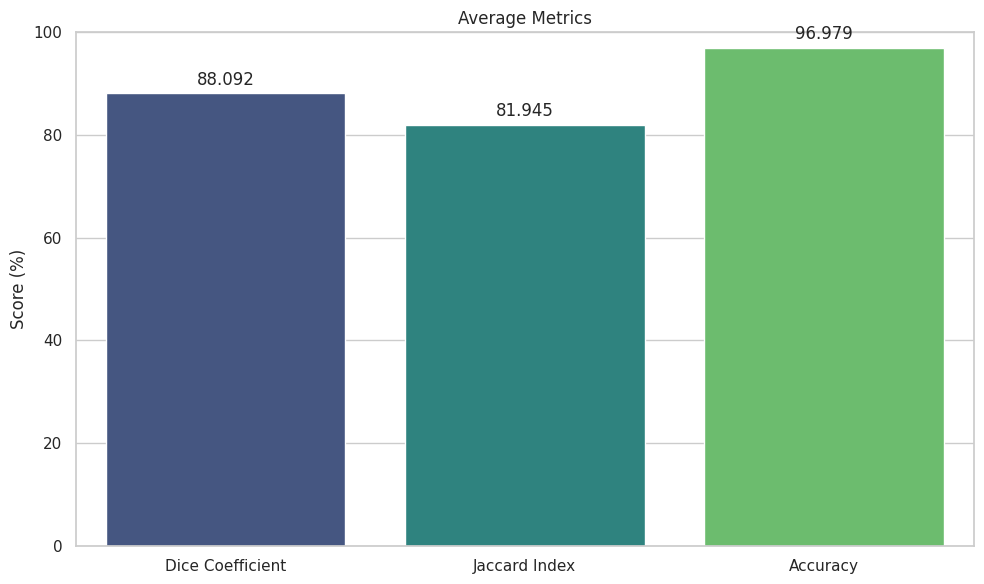

In [13]:
#Tính means :
mean_dice = np.mean(dice_scores) * 100
mean_jaccard = np.mean(jaccard_scores) * 100
mean_accuracy = np.mean(accuracy_scores) * 100

#Dữ liệu trực quan :
metrics = ['Dice Coefficient', 'Jaccard Index', 'Accuracy']
values = [mean_dice, mean_jaccard, mean_accuracy]

#Tạo biểu đồ cột :
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=metrics, y=values, palette="viridis")

#Thêm giá trị của các metric lên cột :
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

#Thiết lập labels và title :
ax.set(ylim=(0, 100))
plt.ylabel('Score (%)')
plt.title('Average Metrics')

#Hiển thị biểu đồ :
plt.tight_layout()
plt.show()

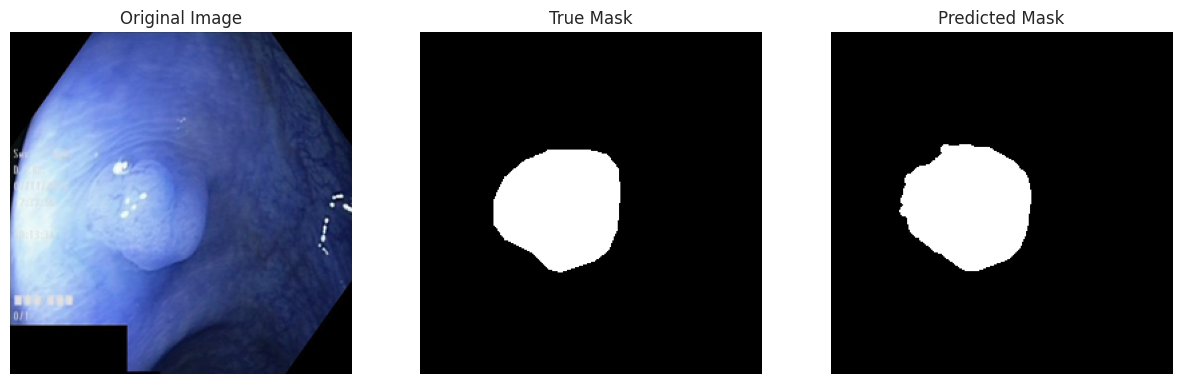

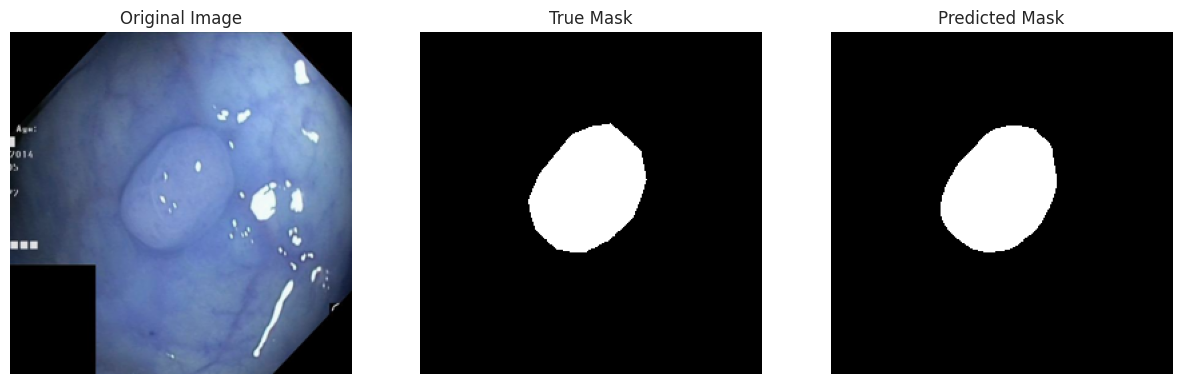

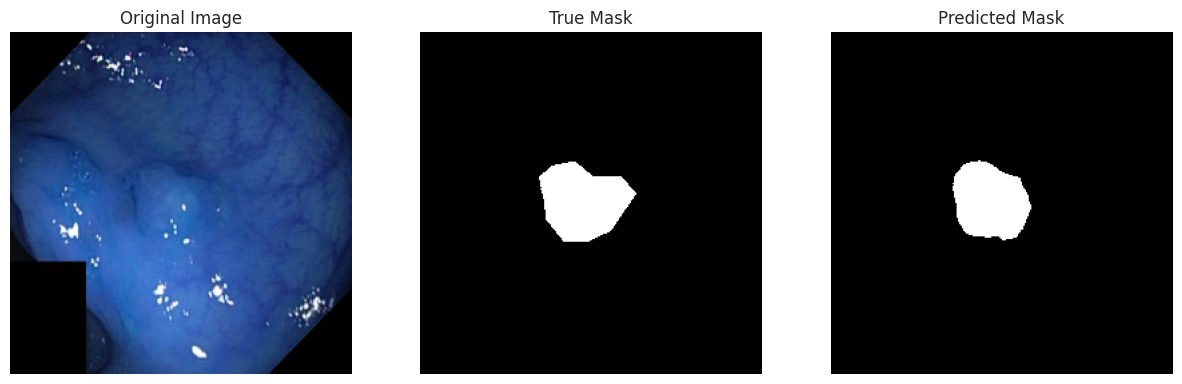

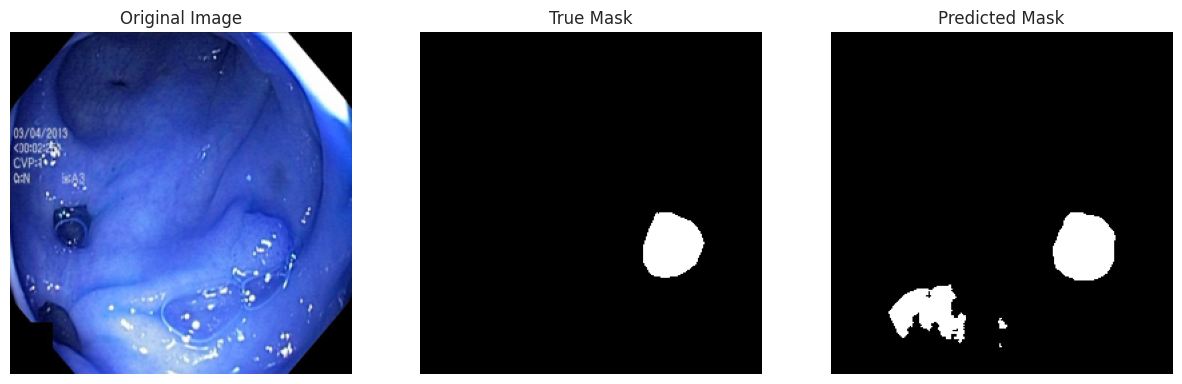

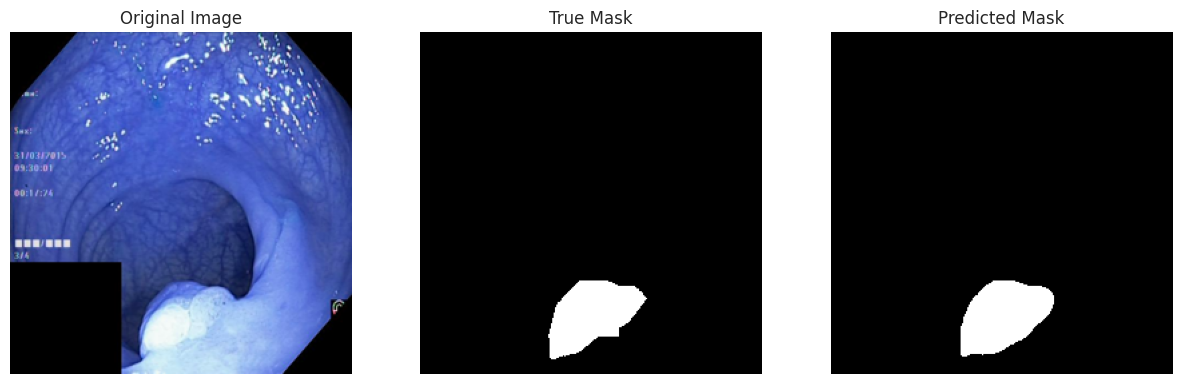

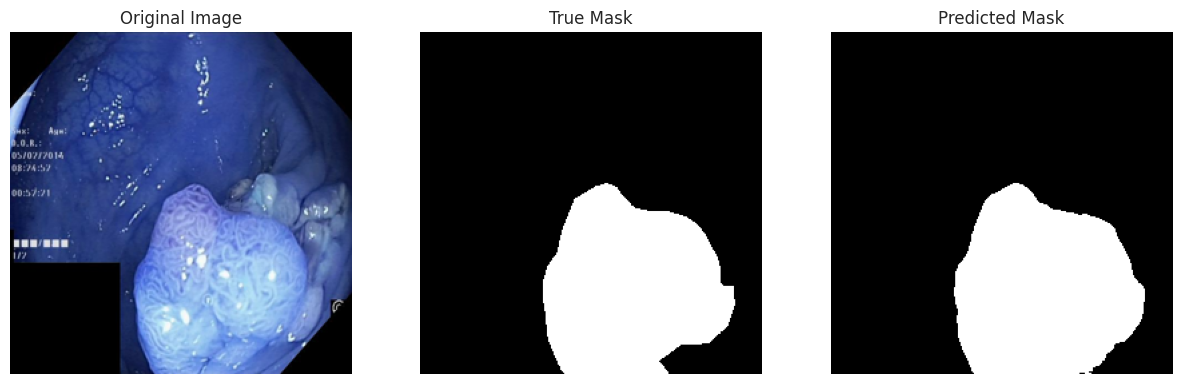

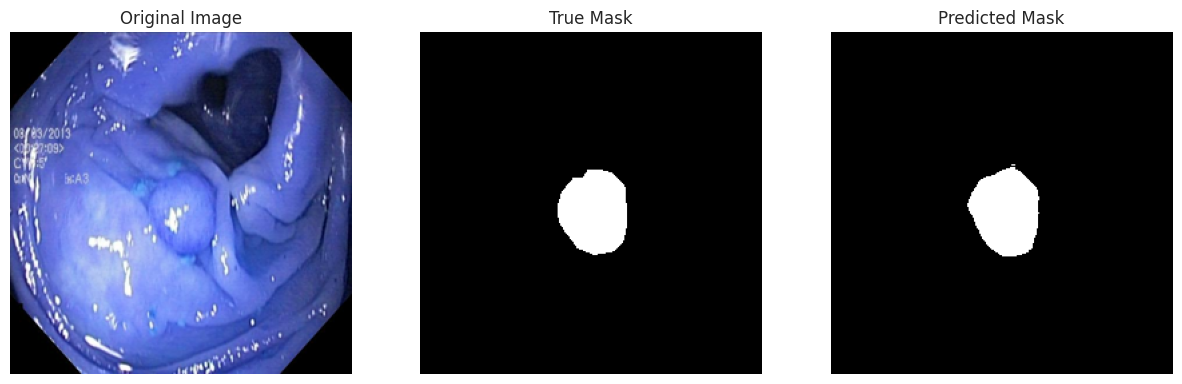

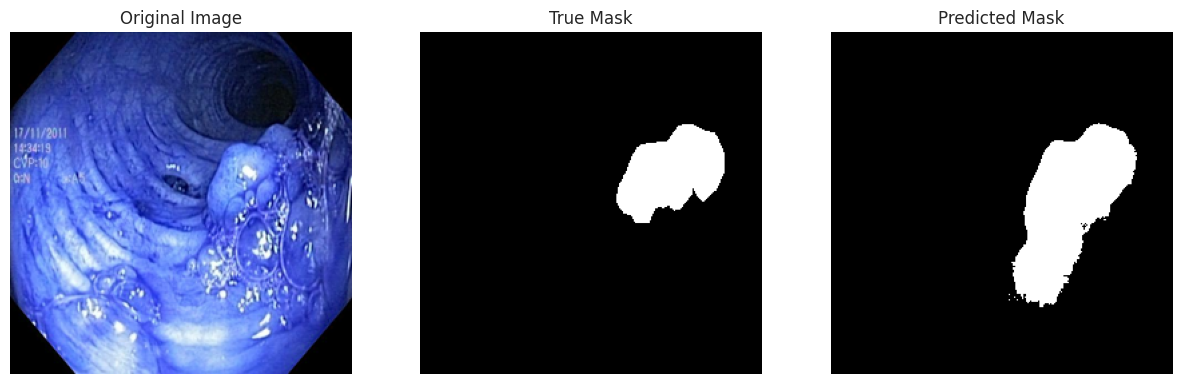

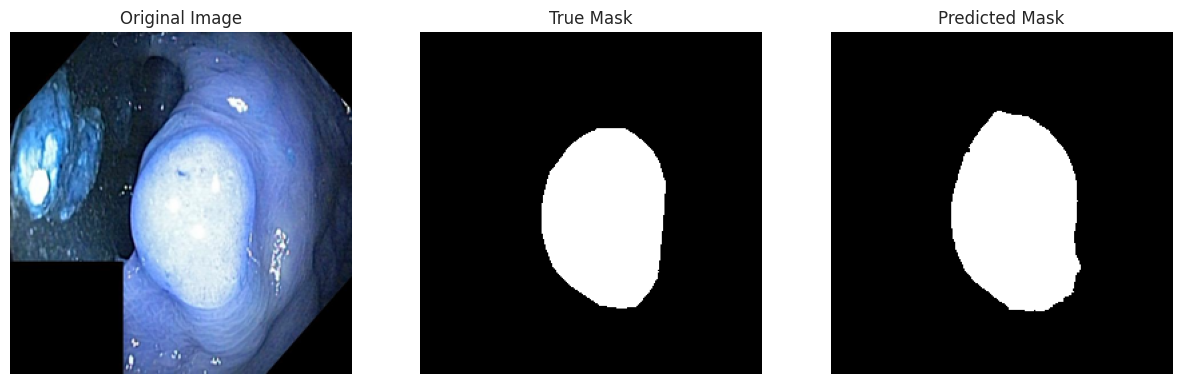

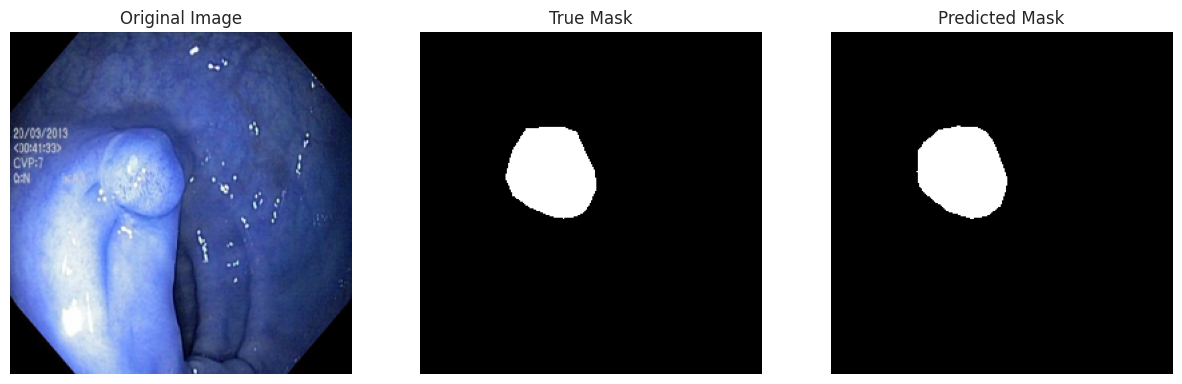

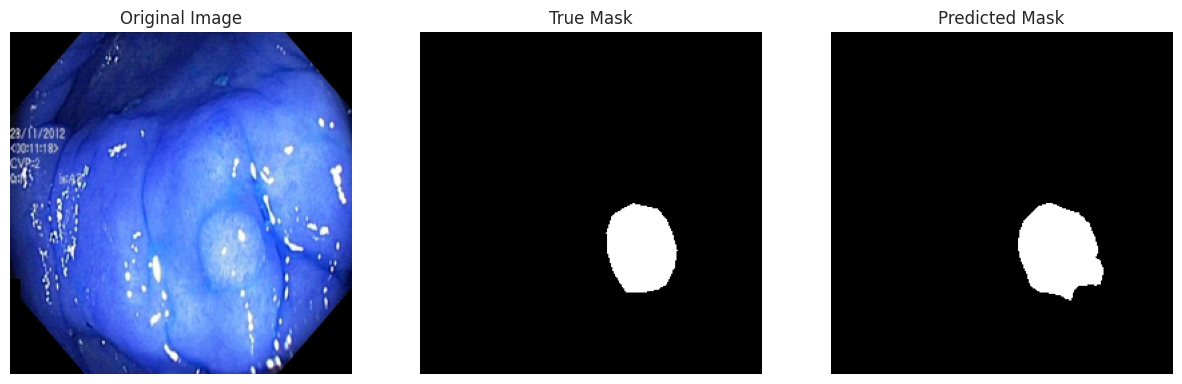

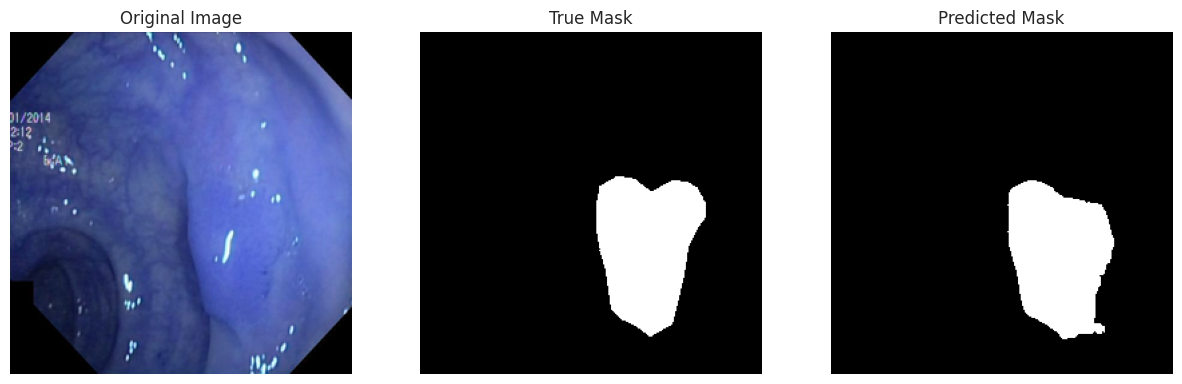

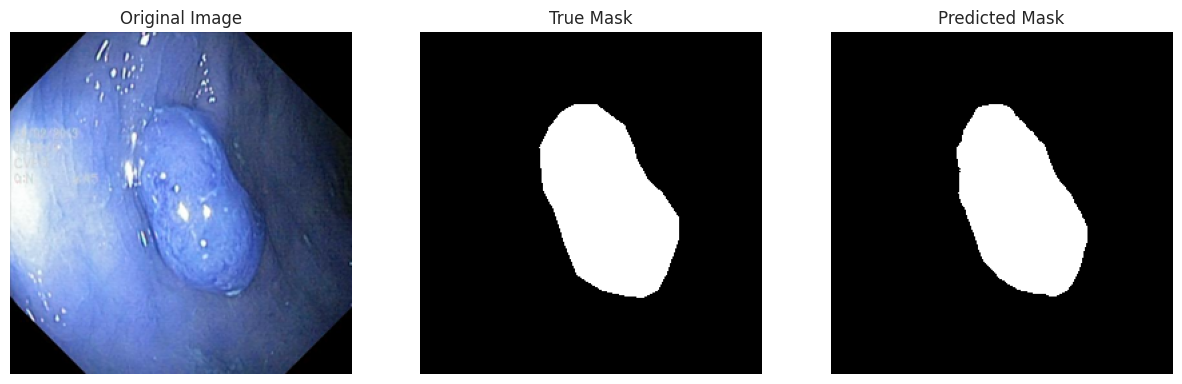

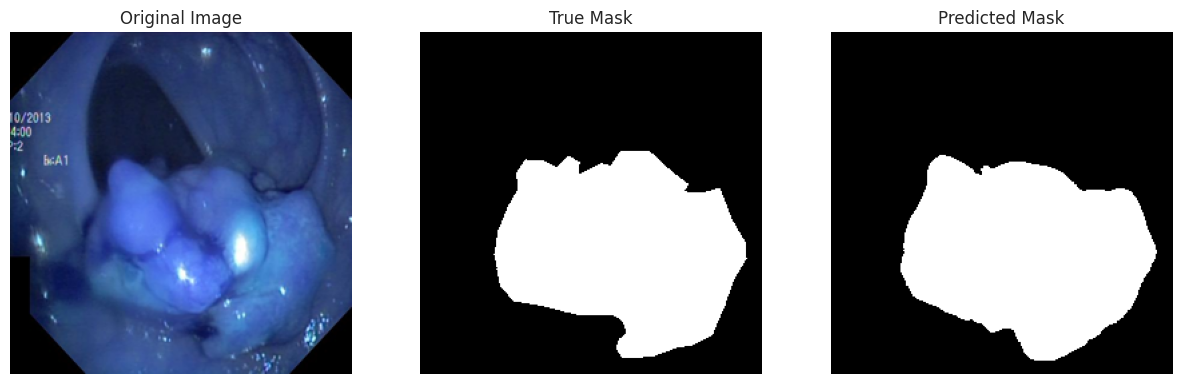

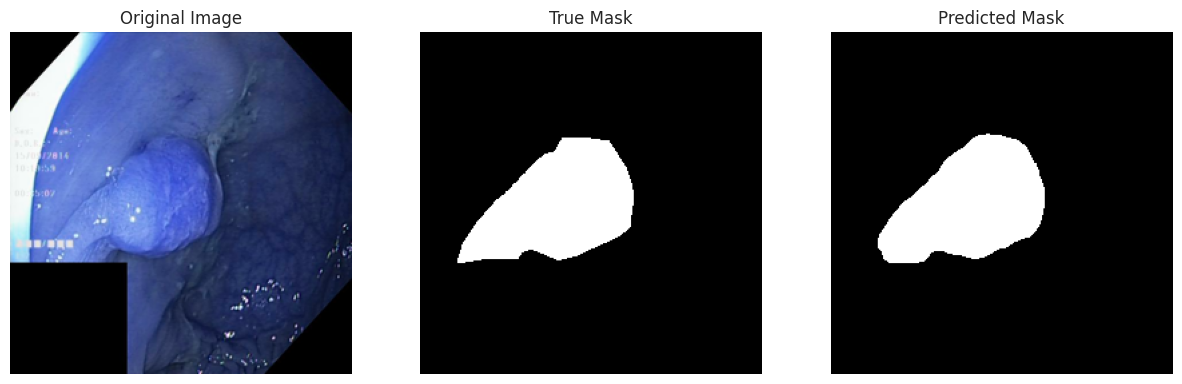

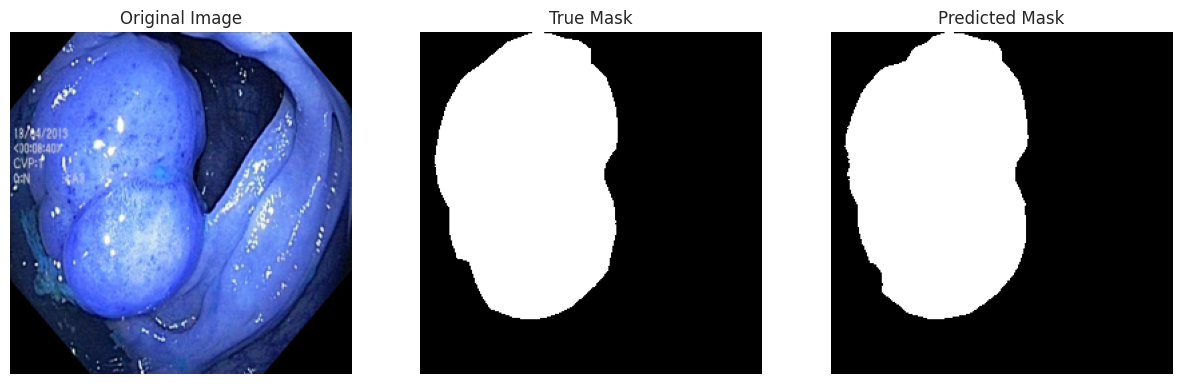

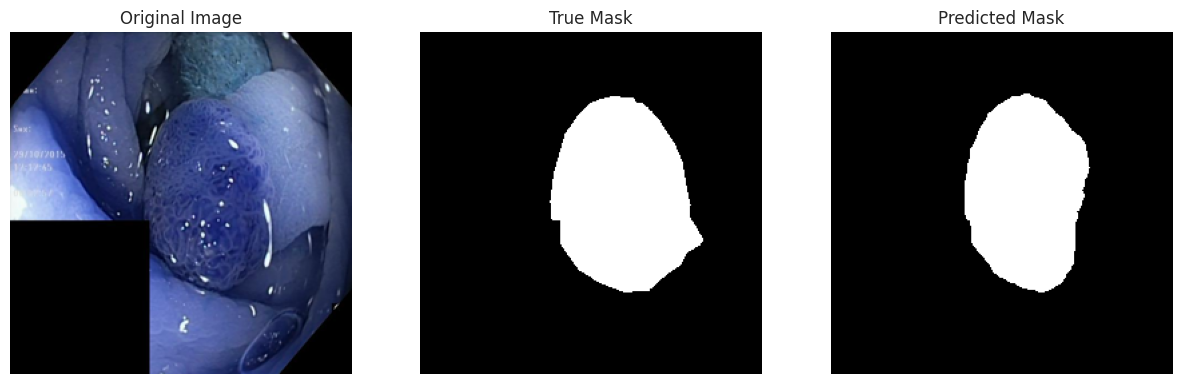

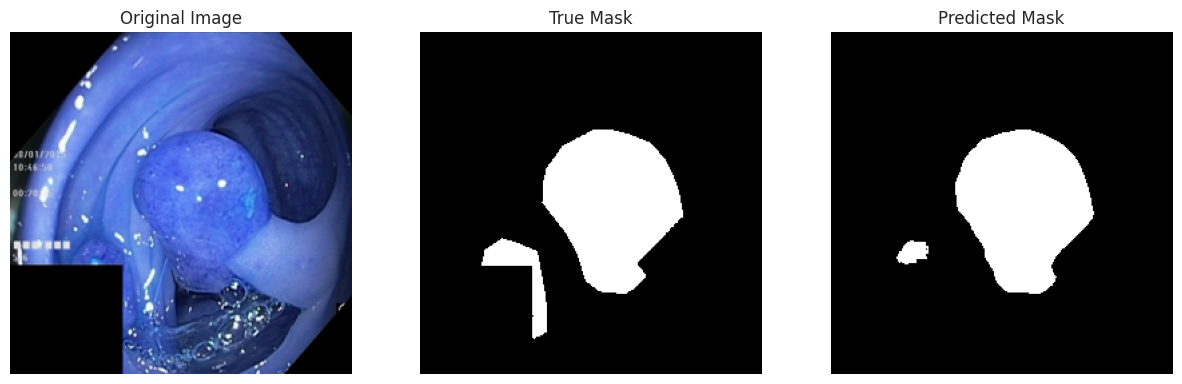

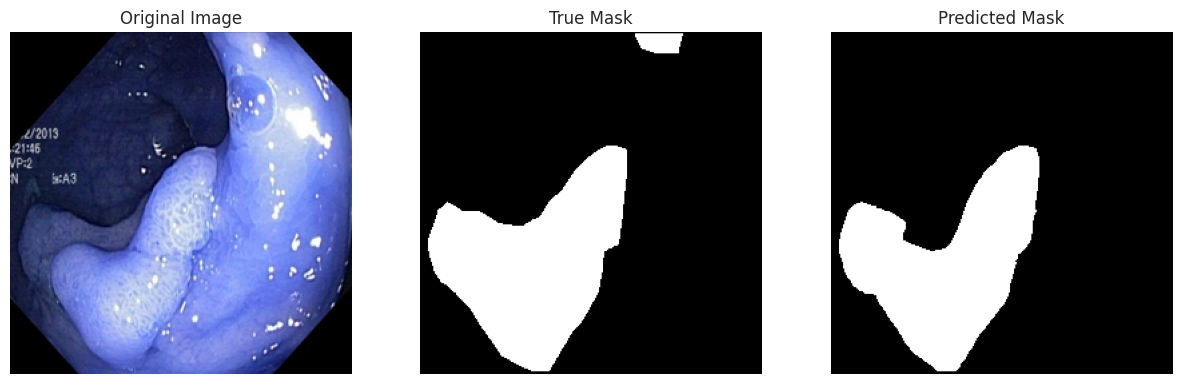

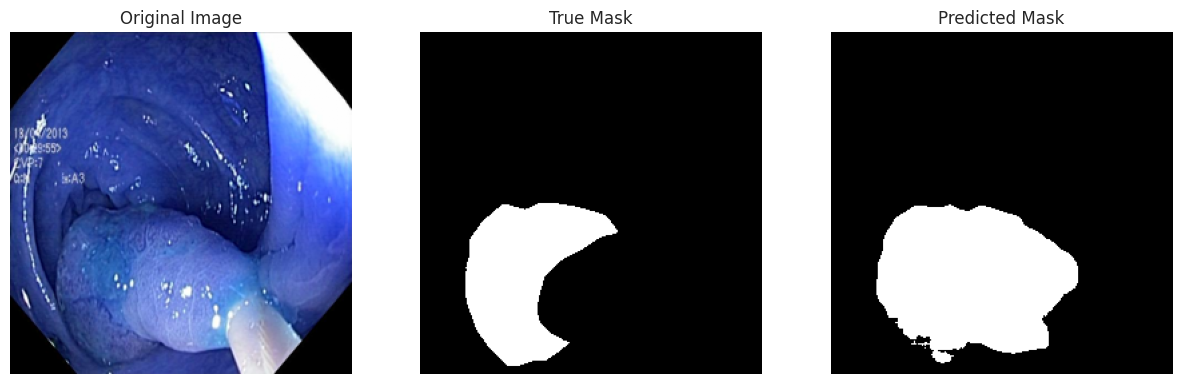

In [14]:
y_pred = model.predict(x_test, batch_size=8, verbose=0)
y_pred_b = (y_pred >= 0.5).astype(np.float32)
Show_Images_Mask_Pred(x_test , y_test, y_pred_b, num_images = 20)

In [15]:
def plot_training_history(train_scores, val_scores, title, ylabel):
    """
    Plots training and validation metrics together for comparison.

    Parameters:
    - train_scores (list): Training metric values per epoch
    - val_scores (list): Validation metric values per epoch
    - title (str): Title of the plot
    - ylabel (str): Label for the y-axis
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_scores, label="Train")
    plt.plot(val_scores, label="Val")
    
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title + " Over Epochs")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

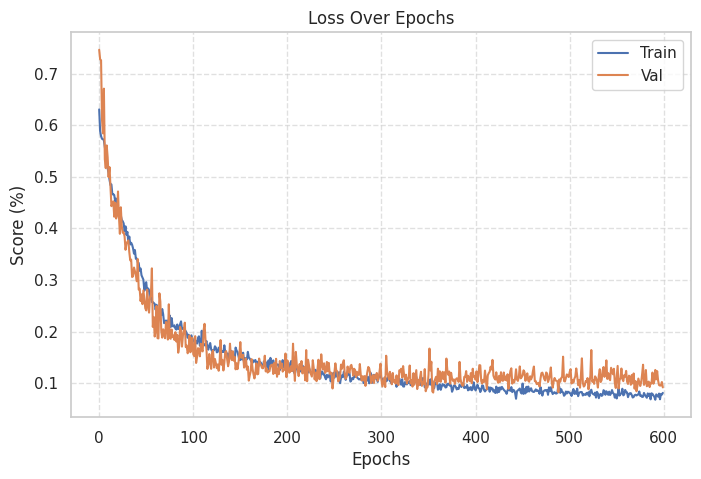

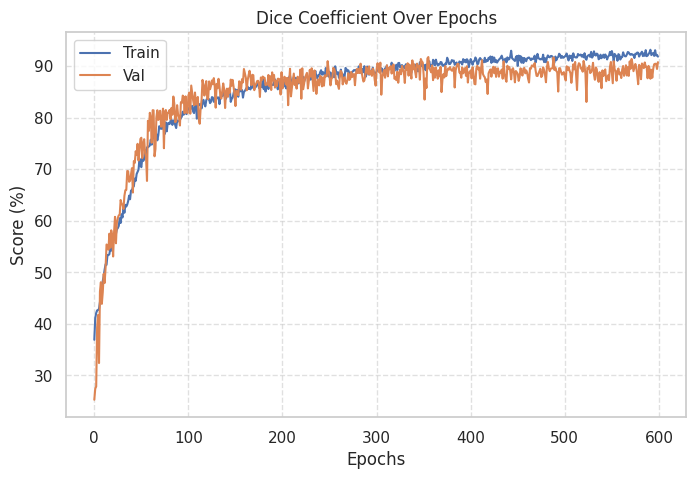

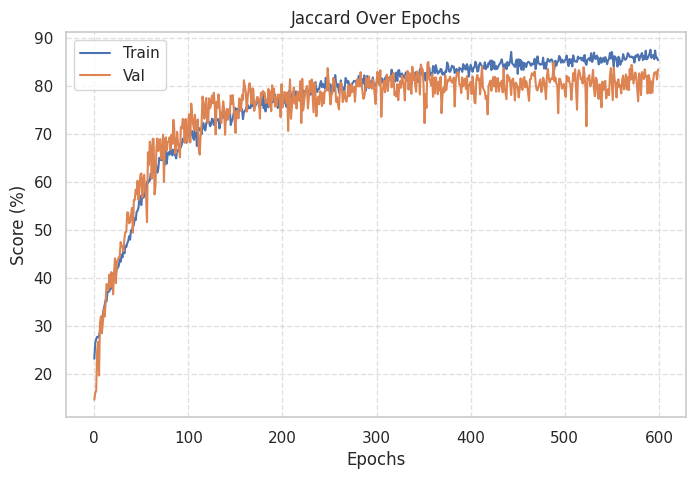

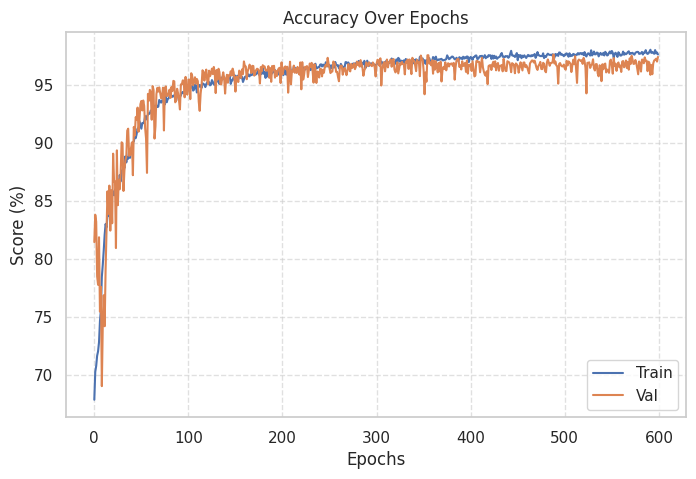

In [16]:
plot_training_history(loss_per_epoch, val_loss_per_epoch, "Loss", "Score (%)")
plot_training_history(dice_per_epoch, val_dice_per_epoch, "Dice Coefficient", "Score (%)")
plot_training_history(jaccard_per_epoch, val_jaccard_per_epoch, "Jaccard", "Score (%)")
plot_training_history(accuracy_per_epoch, val_accuracy_per_epoch, "Accuracy", "Score (%)")